# Kaggle Study Day 24

# Speech representation and data exploration

https://www.kaggle.com/davids1992/speech-representation-and-data-exploration#1.-Visualization

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# 1. Visualization

인간의 청각에는 두 가지 이론, place 이론과 temporal 이론이 있다. 음성 인식에서 입력 spectrogram(fequencies)와 MFCC (Mel-Fequency Cepstral Coefficients), PLP의 두 가지 주요 경향을 본다. 원시적(raw)이고 시간적(temporal)인 데이터는 거의 사용하지 않는다.

몇 가지 레코딩을 시각화 해보자.

## 1.1. Wave and spectrogram

In [2]:
train_audio_path = '../input/train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename)

spectrogram을 계산하는 함수를 정의한다.

spectrogram 값의 로그를 취한다는 것을 알아두자. 이는 plot을 훨씬 더 깔끔하게 하고, 또한 사람이 듣는 방법과 밀접히 연관되어있다. 로그 입력으로 0값이 없다는 것을 확인해야한다.

In [3]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann',
                                            nperseg=nperseg, noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Nyquist 이론에 따르면 주파수(Freqs) 범위는 (0, 8000) 이다.

Text(0.5, 0, 'Seconds')

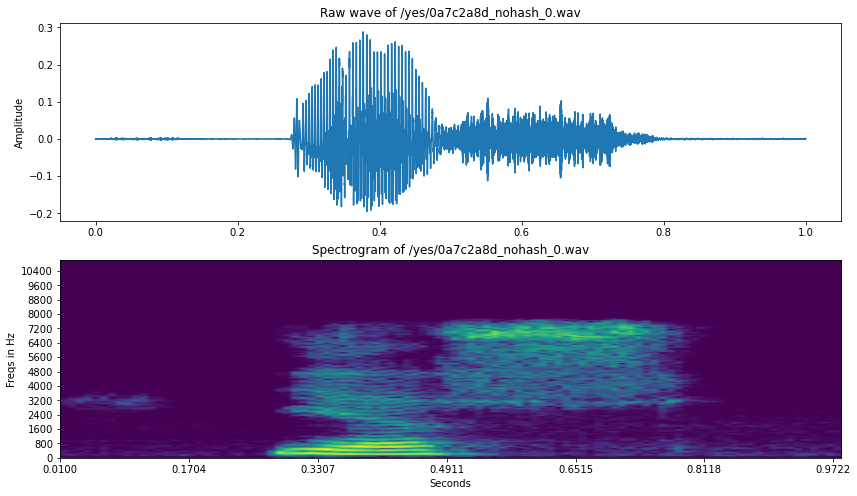

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

spectrogram을 NN의 입력 변수로 사용하면, 변수를 정규화해야한다. (모든 데이터셋에 대해 정규화해야한다. 한 예시로, 적절한 평균과 표준편차를 제공하지 않는다.)

In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

짚고 넘어가야할 흥미로운 사실이 하나 있다. 각 프레임에 대해 최대 160개 변수가 있으며, 주파수는 0과 8000 사이다. 이는 한 변수가 50Hz에 해당한다는 의미다. 하지만, 귀의 주파수 분해는 1000~2000 Hz의 옥타브 내에서 3.6Hz다. 이는 사람이 위와 같은 spectrogram으로 표현되는 것보다 훨씬 더 정밀하고 작은 디테일을 들을 수 있다는 것을 의미한다.

## 1.2. MFCC

MFCC는 인간의 청각 특성을 잘 모방할 준비가 되어있다. librosa 파이썬 패키지를 사용해 MFCC (Mel power spectrogram)을 계산할 수 있다.

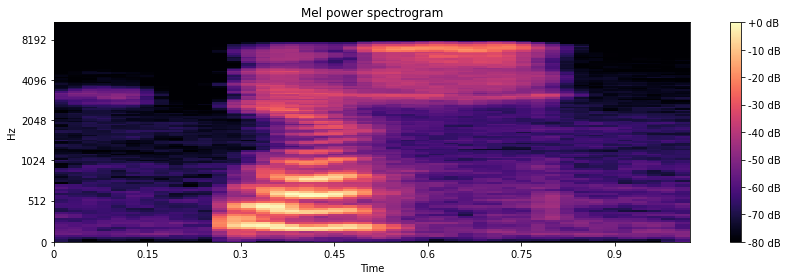

In [7]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# 로그 척도(dB)로 변환. 최대 power(max)를 기준으로 사용
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

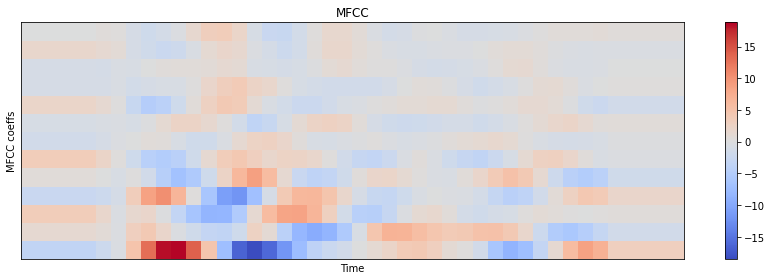

In [8]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

고전적이지만 여전히 최첨단 시스템에서, MFCC 혹은 유사한 기능은 spectrogram 대신 시스템에 입력으로 취해진다.

하지만, end-to-end(종종 신경망 기반) 시스템에서, 가장 일반적인 입력 변수는 아마 raw spectrogram이나 mel power spectrogram일 것이다. 예를 들어 MFCC는 변수를 비상관화하지만, NN은 상관관계가 있는 변수를 잘 처리한다. 또한 mel filter를 이해한다면 용도가 적절하다고 생각할 수 있다. 어떤 것을 선택하는지는 본인 몫이다.

## 1.3. Spectrogram in 3d

In [12]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(title='Spectrogram of "yes" in 3d',
                  scene=dict(yaxis=dict(title='Frequencies'),
                            xaxis=dict(title='Time'),
                            zaxis=dict(title='Log amplitutde')))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.4. Silence removal

파일을 들어보자.

In [13]:
ipd.Audio(samples, rate=sample_rate)

일부 VAD(Voice Activity Detection, 음성 활동 탐지)는 여기서 매우 유용할 것이다. 짧은 말이지만, 그 안에 silence가 많다. 적절한 VAD를 사용하면 training 크기를 줄일 수 있어 학습 속도가 현저히 빨라진다. 처음부터 끝까지 파일의 일부를 잘라 다시 들어보자.(위의 plot에 따르면 4000부터 13000까지)

In [14]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

단어 전체를 들을 수 잇다. 모든 파일을 수동으로 자르고 간단한 plot을 기준으로 이 작업을 하는 건 불가능하다. 하지만 webrtcvad 패키지를 사용해 적절한 VAD를 가질 수 있다.

'y''e''s' 문자소(grapheme)의 추측된 배열과 함께 다시 시각화해보자.

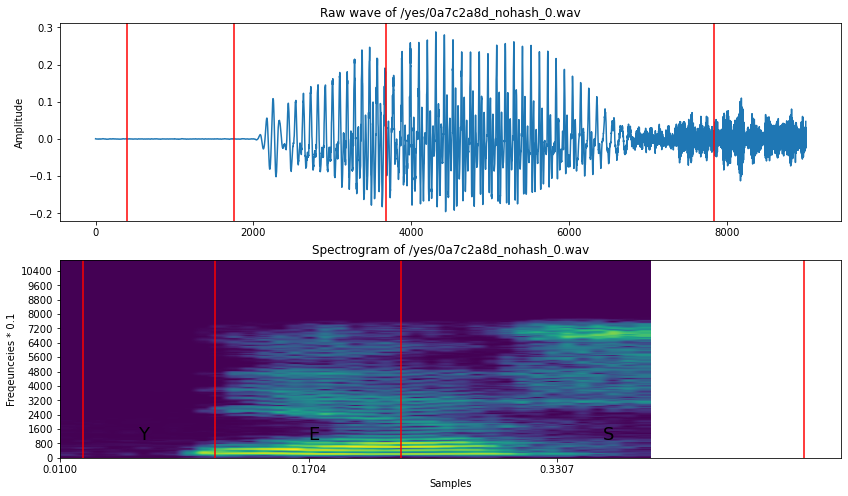

In [15]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqeunceies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5. Resampling - dimensionality reduction

데이터의 또 다른 차원 축소 방법은 레코딩을 다시 샘플링하는 것이다.

레코딩(녹음)은 16k 주파수 샘플이므로 자연스럽지 않게 들릴 수 있고, 우리는 보통 훨씬 더 많은 소리를 듣는다. 그러나 가장 음성과 관련한 주파수는 더 작은 밴드에서 제공된다. GSM 신호가 8000Hz로 샘플링 되는 전화기에 다른 사람이 말하는 것을 이해할 수 있는 이유다.

요약하면, 데이터셋을 8k로 다시 샘플링할 수 있다. 중요하지 않은 정보는 제거하고 데이터 크기를 줄인다. 대회에서는 위험할 수도 있다.

FFT(Fast Fourier Transform)을 계산하는 함수를 정의해보자.

In [26]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT는 대칭이므로 전반부만 취한다.
    # 또한 FFT는 복잡해서 실제 부분(abs)만 취할 수 있다.
    return xf, vals

레코딩을 다시 읽어오고 재샘플링해서 들어보자. 또한 FFT를 비교할 수 있다. 원래 신호에는 4000Hz 이상의 정보가 거의 없다.

In [17]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

samples, sample_rate = librosa.load(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [18]:
ipd.Audio(samples, rate=sample_rate)

In [20]:
ipd.Audio(resampled, rate=new_sample_rate)

차이가 거의 없다!

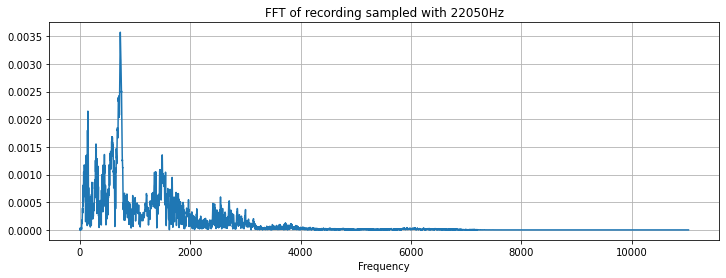

In [27]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + 'Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

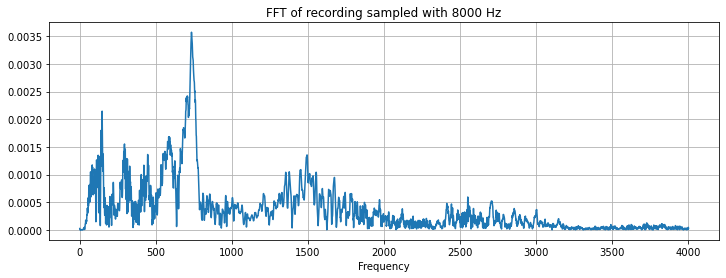

In [30]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

이렇게 해서 데이터셋 크기를 두 번 줄였다.

## 1.6. Features extraction steps

변수 추출 알고리즘
1. Resampling
2. VAD
3. 신호 길이가 같도록 0으로 패딩
4. Log spectrogram (혹은 MFCC, 혹은 PLP)
5. 평균, 표준편차를 이용한 변수 정규화
6. temporal 정보를 얻기 위해 주어진 수의 프레임 쌓기

노트북에서 할 수 없는 일이다. 0부터 쓰는 것은 의미가 없고 모든 것을 취할 준비가 되어있지만, 패키지에서 Kernels를 임포트할 수 없다.